Se cargan las librerías:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
np.random.seed(4711)

## Cuenta @REALMADRID

Se carga en primer lugar la base de datos de la cuenta @realmadrid:

In [ ]:
df_realmadrid_def=pd.read_excel("df_realmadrid_def_sindup2_bool.xlsx")
#df_realmadrid_def=pd.read_excel("df_realmadrid_def_sindup3_bool.xlsx")
df_realmadrid_def = df_realmadrid_def.drop('Unnamed: 0', axis=1)
df_realmadrid_def

Se definen las variables numéricas y no numéricas:

In [ ]:
cols_categoricas = ['music_sonido original','music_author_Real Madrid C.F.']
df_realmadrid_def[cols_categoricas] = df_realmadrid_def[cols_categoricas].astype("category")

Se visualiza el comportamiento de las visualizaciones respecto a las variables numéricas:

In [ ]:
#listado de variables numericas excepto stats_playCount
cols_numericas = (df_realmadrid_def
                  .drop(columns=["stats_playCount"])
                  .select_dtypes(include=np.number)
                  .columns.tolist())
cols_numericas

# son 15 variables numericas
# el plot seran 5 filas y 3 columnas

fig, axes = plt.subplots(4, 3, figsize=(12, 12))
axes = axes.flatten()
for i, col in enumerate(cols_numericas):
    sns.regplot(data=df_realmadrid_def,
                x=col, y="stats_playCount",
                ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()


Correlación, donde se visualiza la correlación entre las variables numéricas. La correlación de Pearson es una medida estadística que se utiliza para cuantificar la relación lineal entre dos variables continuas, y estas variables continuas deben ser lineales.

In [ ]:
cols = df_realmadrid_def.columns.tolist()
cols.insert(0, cols.pop(cols.index("stats_playCount")))
auto_df = df_realmadrid_def.reindex(columns= cols)

automobile_corr = df_realmadrid_def.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(automobile_corr, annot=True, fmt=".2f");


Visualización variables categóricas:

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(5, 7))
axes = axes.flatten()
for i, col in enumerate(cols_categoricas):
    sns.boxplot(data=auto_df,
                x="stats_playCount", y=col,
                ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()


In [ ]:
!pip install pingouin

In [ ]:
import pingouin as pg
pg.anova(data=df_realmadrid_def, dv='stats_playCount', between='music_sonido original', detailed=True)

In [ ]:
import pingouin as pg
pg.anova(data=df_realmadrid_def, dv='stats_playCount', between='music_author_Real Madrid C.F.', detailed=True)

Un p-value es superior a 0.1 es una evidencia muy débil en contra de la hipótesis núla de que todos los grupos tienen la misma media. El valor de eta cuadrado ( η2 ) es de 0.001 y 0.019, lo ue puede considerarse como un tamaño de efecto pequeño.

Se va realizar una imputacion simple sin tener en cuenta un analisis mas profundo de los datos y la distribucion de los mismos.

Las variables numericas se imputaran con la media y las variables categoricas con la moda.

Creacion de pipelines de transformacion, la codificacion es:

In [ ]:
cols_numericas = ['author_followers', 'music_preciseDuration.preciseDuration',
       'stats_diggCount', 'stats_shareCount', 'stats_commentCount', 'stats_collectCount', 'video_duration',
       'video_bitrate', 'video_volumeInfo.Loudness', 'video_volumeInfo.Peak',
       'dias_fecactual_fecpublic', 'tasa_compromiso']

cols_categoricas = ['music_sonido original','music_author_Real Madrid C.F.']

In [ ]:
numeric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('numericas', numeric_pipe, cols_numericas),
        ('categoricas', categorical_pipe, cols_categoricas)
        ])
preprocessor

### Modelo de regresión

Dividir el dataset en entrenamiento y prueba

In [ ]:
from sklearn.model_selection import train_test_split

X_features = auto_df.drop('stats_playCount', axis='columns')
Y_target = auto_df['stats_playCount']

x_train, x_test, y_train, y_test = train_test_split(X_features,
                                                    Y_target,
                                                    test_size=0.3,
                                                    random_state=42)


x_train.shape, y_train.shape

In [ ]:
x_test.shape, y_test.shape

#### Regresión modelo simple

Cross Validation modelo simple

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings("ignore")

result_dict = {}

FEATURES = list(x_train.columns)
FEATURES

In [ ]:
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

def entrenar_modelo(modelo,
                    preprocessor: ColumnTransformer,
                    x_data: pd.DataFrame,
                    y_data: pd.Series,
                    test_frac:float=0.3,
                  ):

    # dividir el dataset en entrenamiento y prueba
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,
                                                        random_state=42,
                                                        test_size=test_frac)
    # crear el pipeline con el preprocesador y el modelo
    regressor_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                                     ("model", modelo)])

    # entrenar el pipeline de regresion
    model = regressor_pipe.fit(x_train, y_train)

    y_pred_train = model.predict(x_train)

    # predecir con el pipeline de regresion
    y_pred = model.predict(x_test)

    rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False)

    train_score = mean_absolute_error(y_train, y_pred_train)
    test_score = mean_absolute_error(y_test, y_pred)
    R1=r2_score(y_train, y_pred_train)
    R=r2_score(y_test, y_pred)
    #R1=r2_score(y_train, y_pred_train)
    print("Entrenamiento_score (MSE) : " , train_score)
    print("Prueba_score (MSE) : ", test_score)
    print("RMSE : ", rmse)
    print("R2 entrenamiento: ", R1)
    print("R2 test: ", R)


    return {
            'Entrenamiento_score': train_score,
            'Prueba_score': test_score,
            'RMSE': rmse,
            'R2_t':R1,
            'R2':R
           }

Función para comparar resultados:

In [ ]:
# Funcion para comparar los resultados de los modelos
#se van a almacenar en un diccionario
def compare_results():
    for key in result_dict:
        print('Regresion: ', key)
        print('Entrenamiento score: ', result_dict[key]['Entrenamiento_score'])
        print('Prueba score: ', result_dict[key]['Prueba_score'])
        print('RMSE: ', result_dict[key]['RMSE'])
        print('R2 entrenamiento: ', result_dict[key]['R2_t'])
        print('R2 test: ', result_dict[key]['R2'])
        print()


Se crea un modelo simple:

In [ ]:
result_dict['Dummy Regressor'] = entrenar_modelo(DummyRegressor(strategy='median'),
                                                 preprocessor,
                                                 x_train,
                                                 y_train)


Regresión lineal:

In [ ]:
result_dict['Linear Regressor'] = entrenar_modelo(LinearRegression(),
                                                 preprocessor,
                                                 x_train,
                                                 y_train)


Lasso:

In [ ]:
result_dict['Lasso'] = entrenar_modelo(Lasso(alpha=0.5),
                                       preprocessor,
                                       x_train,
                                       y_train)

Ridge:

In [ ]:
result_dict['Ridge'] = entrenar_modelo(Ridge(alpha=0.5),
                                       preprocessor,
                                       x_train,
                                       y_train)


Elasticnet:

In [ ]:
result_dict['Elasticnet'] = entrenar_modelo(ElasticNet(alpha=1, l1_ratio=0.5,
                                                       max_iter= 100000,
                                                       warm_start= True),
                                            preprocessor,
                                            x_train,
                                            y_train)


KNR:

In [ ]:
result_dict['KNR'] = entrenar_modelo(KNeighborsRegressor(n_neighbors=10),
                                     preprocessor,
                                     x_train,
                                     y_train)


Decision Tree:

In [ ]:
result_dict['Decision Tree'] = entrenar_modelo(DecisionTreeRegressor(max_depth=2),
                                               preprocessor,
                                               x_train,
                                               y_train)


In [ ]:
compare_results()

Random forest:

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

l_estimators = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4056]

total_scores = []
for estimators in l_estimators:
   fold_accuracy = []
   regressor =  RandomForestRegressor(n_estimators= estimators,
                  criterion='absolute_error', random_state=0)
   result_dict['Random Forest'] = entrenar_modelo(RandomForestRegressor(n_estimators= estimators, criterion='absolute_error', random_state=0),
                                               preprocessor,
                                               x_train,
                                               y_train)


In [ ]:
# Crear un diccionario solo con los resultados de prueba de cada modelo
nombre_modelos = result_dict.keys()
resultados_train = {} # crear diccionario vacio
resultados_test = {} # crear diccionario vacio
for nombre in nombre_modelos:
    resultados_train[nombre] = result_dict[nombre]['Entrenamiento_score']
    resultados_test[nombre] = result_dict[nombre]['Prueba_score']

df_comparacion = pd.DataFrame([resultados_train, resultados_test],
                              index=['train', 'test'])


In [ ]:
# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 4))
df_comparacion.T.plot(kind='bar', ax=ax)

# Adjust the layout
ax.set_ylabel('MAE score')
ax.set_title('Comparacion de Modelos [MAE] ')

# Set the x-tick labels inside the bars and rotate by 90 degrees
ax.set_xticks(range(len(df_comparacion.columns)))
ax.set_xticklabels([])

# Draw the x-tick labels inside the bars rotated by 90 degrees
for i, label in enumerate(df_comparacion.columns):
    bar_center = (df_comparacion.loc['train', label] +
                  df_comparacion.loc['test', label]) / 2
    ax.text(i, bar_center, label, ha='center',
            va='center_baseline', rotation=45)

#plot line at DUmmerRegressor result
ax.axhline(df_comparacion['Dummy Regressor']['test'],
           color='red',
           linestyle='--',
           alpha=0.8)

plt.tight_layout()


### Cross Validation - Seleccion de Modelos
Analizar la varianza de los resultados para obtener los que tengan mejor resultado.

In [ ]:
# lista para almacenar cada uno los modelos seleccionados para el cross validation
models = []

# Alamcenando los modelos como una tupla (nombre, modelo)
models.append(('LinearRegression',LinearRegression()))
models.append(('Lasso',Lasso(alpha=0.5)))
models.append(('Elastic_net',ElasticNet(alpha=1,
                                        l1_ratio=0.5,
                                        max_iter= 100000,
                                        warm_start= True)))
models.append(('Kneighbors',KNeighborsRegressor(n_neighbors=10)))
models.append(('Decision_tree',DecisionTreeRegressor(max_depth=2)))
#models.append(('SVR',SVR(kernel='linear', epsilon=0.05, C=0.3)))


In [ ]:
# Grabar los resultados de cada modelo
from sklearn import model_selection

#Semilla para obtener los mismos resultados de pruebas
seed = 2
results = []
names = []
scoring = 'neg_mean_absolute_error'
for name, model in models:
    # Kfold cross validation for model selection
    kfold = model_selection.KFold(n_splits=10)
    model_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                                 ("model", model)])
    #X train , y train
    cv_results = model_selection.cross_val_score(model_pipe, x_train, y_train,
                                                 cv=kfold, scoring=scoring)
    # la metrica neg_mean_absolute_error se debe convertir en positiva
    cv_results = np.abs(cv_results)

    results.append(cv_results)
    names.append(name)
    msg = f"({name}, {cv_results.mean()}, {cv_results.std()}"
    print(msg)

In [ ]:
plt.figure(figsize = (8,4))
result_df = pd.DataFrame(results, index=names).T
sns.boxplot(data=result_df)
plt.title("Resultados de Cross Validation")
plt.show()

In [ ]:
plt.figure(figsize = (8,4))
sns.lineplot(data=result_df)
plt.title("Resultados de cada Kfold")
plt.show()


Comparación estadística de modelos

In [ ]:
from scipy.stats import f_oneway

model1 = result_df['LinearRegression']
model2 = result_df['Lasso']
model3 = result_df['Elastic_net']
model4 = result_df['Kneighbors']
model5 = result_df['Decision_tree']
#model6 = result_df['SVR']

#statistic, p_value = f_oneway(model1, model2, model3, model4, model5, model6)

statistic, p_value = f_oneway(model1, model2, model3, model4, model5)

#statistic, p_value = f_oneway(model1, model2)

print(f'Statistic: {statistic}')
print(f'p_value: {p_value}')

alpha = 0.05  # nivel de significancia

if p_value < alpha:
    print("Existe una diferencia estadísticamente "
          "significativa en los resultados de"
          " cross-validation de los modelos.")
else:
    print("No Existe una diferencia estadísticamente "
          "significativa en los resultados de "
          "cross-validation de los modelos.")


### Hyper Parameter Tunning
Optimizacion de hiperparametros, Se seleccionan los mejores modelos que tengan diferentes formas de funcionamiento.

In [ ]:
from sklearn.model_selection import GridSearchCV

Lasso regression:

In [ ]:
parameters = {'model__alpha': [0.2, 0.4, 0.5 ,0.6, 0.7, 0.8, 0.9, 1.0]}

lasso_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                             ("model", Lasso())])

grid_search = GridSearchCV(lasso_pipe, parameters, cv=5,
                           return_train_score=True,
                           scoring='neg_mean_absolute_error')
grid_search.fit(x_train, y_train);


Resultados de hiperparametrización:

In [ ]:
# la medida neg_mean_absolute_error se debe convertir en positiva
print(f"Mejor resultado = {abs(grid_search.best_score_)}")
print(f"Mejor std = {grid_search.cv_results_['std_test_score'][grid_search.best_index_]}")
print(f"Mejor parametros = {grid_search.best_params_}")


In [ ]:
# Para ver todos los resultados del cross validation
# No es necesario, solo es informativo para ver como varia el modelo
for i in range(len(parameters['model__alpha'])):
    print('Parametros: ', grid_search.cv_results_['params'][i])
    print('Promedio Score Prueba: ', np.abs(grid_search
                                            .cv_results_['mean_test_score'][i]))
    print('Std Score Prueba: ', grid_search.cv_results_['std_test_score'][i])

    print('Rank: ', grid_search.cv_results_['rank_test_score'][i])


In [ ]:
lasso_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                             ("model", Lasso(alpha=grid_search
                                             .best_params_['model__alpha']))])

lasso_model = lasso_pipe.fit(x_train, y_train)


In [ ]:
y_pred = lasso_model.predict(x_test)
y_pred_train = lasso_model.predict(x_train)

print('Entrenamiento score: ', mean_absolute_error(y_train, y_pred_train))
print('Prueba score: ', mean_absolute_error(y_test, y_pred))
print('R2 train: ', r2_score(y_train, y_pred_train))
print('R2 test: ', r2_score(y_test, y_pred))


KNeighbors regression

In [ ]:
parameters = {'model__n_neighbors': [10, 12, 14, 18, 20, 25, 30, 35, 50]}

knn_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", KNeighborsRegressor())])

grid_search = GridSearchCV(knn_pipe, parameters, cv=5,
                           return_train_score=True,
                           scoring='neg_mean_absolute_error')
grid_search.fit(x_train, y_train);


In [ ]:
print(f"Mejor resultado = {abs(grid_search.best_score_)}")
print(f"Mejor std = {grid_search.cv_results_['std_test_score'][grid_search.best_index_]}")
print(f"Mejor parametros = {grid_search.best_params_}")


In [ ]:
knn_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", KNeighborsRegressor(n_neighbors=grid_search.
                                                         best_params_['model__n_neighbors']))])

kneighbors_model = knn_pipe.fit(x_train, y_train)


In [ ]:
y_pred = kneighbors_model.predict(x_test)
y_pred_train = kneighbors_model.predict(x_train)

print('Entrenamiento score: ', mean_absolute_error(y_train, y_pred_train))
print('Prueba score: ', mean_absolute_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))


Decision Tree:

In [ ]:
parameters = {'model__max_depth': [4, 5, 7, 9, 10],
              'model__max_features': [5, 10, 15, 20,30],
              'model__criterion': ['squared_error',
                                   'absolute_error',
                                   'poisson',
                                   'friedman_mse'],
              }

dt_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", DecisionTreeRegressor())])

grid_search = GridSearchCV(dt_pipe, parameters, cv=5,
                           scoring='neg_mean_absolute_error',
                           return_train_score=True)
grid_search.fit(x_train, y_train);


In [ ]:
print(f"Mejor resultado = {abs(grid_search.best_score_)}")
print(f"Mejor std = {grid_search.cv_results_['std_test_score'][grid_search.best_index_]}")
print(f"Mejor parametros = {grid_search.best_params_}")


In [ ]:
model = DecisionTreeRegressor(max_depth=grid_search.best_params_['model__max_depth'],
                              criterion=grid_search.best_params_['model__criterion'])

dt_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model",model)])
decision_tree_model = dt_pipe.fit(x_train, y_train)


In [ ]:
y_pred = decision_tree_model.predict(x_test)
y_pred_train = decision_tree_model.predict(x_train)

print('Entrenamiento score: ', mean_absolute_error(y_train, y_pred_train))
print('Prueba score: ', mean_absolute_error(y_test, y_pred))
print('R2 train: ', r2_score(y_train, y_pred_train))
print('R2 test: ', r2_score(y_test, y_pred))


Esta diferencia entre entrenamiento y prueba se debe a que el modelo esta sobreajustado (overfitt), es decir, esta memorizando los datos de entrenamiento y no generaliza bien para los datos de prueba.

Este fenomeno se puede reducir con la regularizacion, en este caso con el parametro min_samples_leaf que indica el numero minimo de muestras que debe tener una hoja para que el modelo no siga creciendo. pero como se tienen pocos datos, no se va continuar con este modelo.

In [ ]:
from sklearn.metrics import PredictionErrorDisplay
PredictionErrorDisplay.from_predictions(y_true=y_test,
                                        y_pred=y_pred,
                                        kind="actual_vs_predicted");


In [ ]:
PredictionErrorDisplay.from_predictions(y_true=y_test,
                                        y_pred=y_pred,
                                        kind="residual_vs_predicted");


### Interpretación del modelo

In [ ]:
from sklearn.inspection import permutation_importance

imps = permutation_importance(lasso_pipe, x_test, y_test,
                              n_repeats = 5,
                              scoring= "neg_mean_absolute_error",
                              n_jobs=-1, random_state=42)
fig= plt.figure(figsize=(10,8))
perm_sorted_idx = imps.importances_mean.argsort()
plt.boxplot(imps.importances[perm_sorted_idx].T, vert=False,
            labels=x_test.columns[perm_sorted_idx])
plt.title("Permutation Importances (test set)");

En base a estos resultados se pueden reducir el numero de variables y obtener un modelo mas simple con mas o menos el mismo desempeño.

Viendo las graficas solo tomare las 8 variables mas importantes.

In [ ]:
#los valores estan en orden ascendente, entonces se deben tomar los ultimos 8
# se puede comprobar al comparar con el grafico de barras
cols_seleccionadas = x_test.columns[perm_sorted_idx][-9:].tolist()
cols_seleccionadas

Modelo con menos variables:

In [ ]:
x_train = x_train[cols_seleccionadas]
x_test = x_test[cols_seleccionadas]
x_train.head()

In [ ]:
cols_seleccionadas

En este caso, todas las variables son numéricas:

In [ ]:
cols_seleccionadas_num=['stats_collectCount',
 'video_bitrate',
 'video_volumeInfo.Peak',
 'dias_fecactual_fecpublic',
 'video_duration',
 'music_preciseDuration.preciseDuration',
 'tasa_compromiso',
 'stats_diggCount']

#cols_seleccionadas_num=['video_volumeInfo.Peak', 'tasa_compromiso', 'dias_fecactual_fecpublic', 'stats_commentCount', 'author_followers', 'stats_collectCount', 'stats_diggCount']

cols_seleccionadas_cat=['music_author_Real Madrid C.F.']

#cols_seleccionadas_cat=['music_sonido original']

numeric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('numericas', numeric_pipe, cols_seleccionadas_num),
        ('categoricas', categorical_pipe, cols_seleccionadas_cat)
        ])


model = Lasso(alpha=1.0)

lasso_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", model)])
lasso_model = lasso_pipe.fit(x_train, y_train)


In [ ]:
y_pred = lasso_model.predict(x_test)
y_pred_train = lasso_model.predict(x_train)

print('Entrenamiento score: ', mean_absolute_error(y_train, y_pred_train))
print('Prueba score: ', mean_absolute_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))


### Procesamiento y Modelo final con scikit-learn

In [ ]:
cols_seleccionadas

In [ ]:
columnas=['author_followers',
 'stats_collectCount',
 'music_author_Real Madrid C.F.',
 'video_bitrate',
 'video_volumeInfo.Peak',
 'dias_fecactual_fecpublic',
 'video_duration',
 'music_preciseDuration.preciseDuration',
 'tasa_compromiso',
 'stats_diggCount','stats_playCount']

auto_df=df_realmadrid_def[columnas]


Se dividen los datos en las variables de entrada y la variable de salida:

In [ ]:
X = auto_df.drop('stats_playCount', axis='columns')
y = auto_df['stats_playCount']

In [ ]:
lasso_model = lasso_pipe.fit(X, y)

Se selecciona el modelo que obtuvo mejores resultados en la hiperparametrizacion y sus resultados eran buenos con el dataset de prueba (test):

In [ ]:
from joblib import dump# libreria de serializacion

# grabar el modelo en un archivo
dump(lasso_model, 'lasso_model.joblib')
import pandas as pd
from joblib import load

modelo = load('lasso_model.joblib')
modelo



In [ ]:
# tomar dos datos de entrada para realizar la prediccion, eliminando la columna de estudio
datos_prueba = X. sample(50)
datos_prueba


In [ ]:
# resultados de predicion con el modelo
#modelo.predict(datos_prueba)
modelo.predict(X)

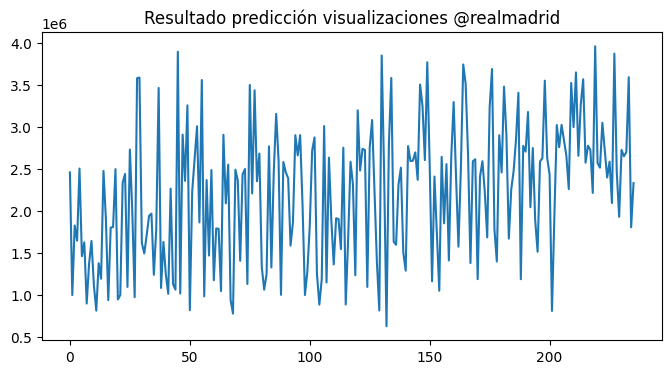

In [ ]:
plt.figure(figsize = (8,4))
sns.lineplot(data=modelo.predict(X))
plt.title("Resultado predicción visualizaciones @realmadrid")
plt.show()

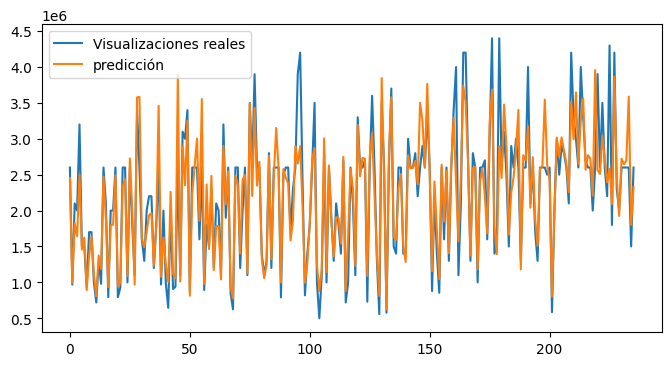

In [ ]:
plt.figure(figsize = (8,4))
plt.plot(y,label='Visualizaciones reales')
plt.plot(modelo.predict(X), label='predicción')
plt.legend()
plt.show()